# 성능 평가지표

## 1. 정확도 
- 실제 데이터와 예측 데이터가 얼마나 같은지 판단하는 지표
- 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
- 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 수 없음

In [17]:
# BaseEstimator를 상속받으면 Customized 형태의 Estimator를 생성할 수 있음
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] = 0
            else :
                pred[i] = 1
                
        return pred

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import numpy as np

# null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Embarked', 'Sex']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [19]:
titanic_df = pd.read_csv("titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,test_size=0.2, random_state=0)

In [20]:
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print(accuracy_score(y_test, mypredictions))

0.7877094972067039


In [21]:
# 불균형한 레이블 값 분포
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        # 입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0으로 만들어 반환
        return np.zeros((len(X), 1), dtype=bool)

digits=load_digits()
y=(digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

print('레이블 테스트 세트 크기', y_test.shape)
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 (450,)
0    405
1     45
dtype: int64


In [22]:
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print(accuracy_score(y_test, fakepred))

0.9


## 2. 오차행렬
- 이진 분류에서 성능 지표로 잘 활용됨
- 4분면의 왼쪽, 오른쪽 => 예측된 클래스 값 기준 N,P
- 4분면의 위쪽, 아래쪽 => 실제 클래스 값 기준 N,P
### TN / TP
### FN / FP

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

## 3. 정밀도와 재현율
- 정밀도 = TP / (FP + TP)              | 양성 예측 중 실제 값이 Positive로 일치하는 것, FP을 낮추는 것에 초점
- 재현율 (민감도) = TP / (FN + TP)     | 실제 양성 중 실제 값이 Positive로 일치하는 것, FN을 낮추는 것에 초점

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [25]:
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv("titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
# 정밀도/ 재현율 트레이드오프 : 어느 한쪽을 강제로 높이면 다른 하나의 수치가 떨어지기 쉽다.
# predict_proba(X_Test) : 테스트 피처 레코드의 개별 클래스 예측 확률을 반환
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba shape:',pred_proba.shape)
print('샘플 3개 추출:\n', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print(pred_proba_result[:3])

pred_proba shape: (179, 2)
샘플 3개 추출:
 [[0.46162417 0.53837583]
 [0.87858538 0.12141462]
 [0.87723741 0.12276259]]
[[0.46162417 0.53837583 1.        ]
 [0.87858538 0.12141462 0.        ]
 [0.87723741 0.12276259 0.        ]]


In [32]:
# Binarizer 클래스
# binarzer.fit_transform() -> threshold보다 같거나 작으면 0값, 크면 1값
from sklearn.preprocessing import Binarizer
X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

binarizer =Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [34]:
pred_proba[:, 1].reshape(-1, 1)

array([[0.53837583],
       [0.12141462],
       [0.12276259],
       [0.1171482 ],
       [0.14495399],
       [0.11768704],
       [0.11164519],
       [0.79087429],
       [0.217473  ],
       [0.62999708],
       [0.10010532],
       [0.12523082],
       [0.1227685 ],
       [0.11169063],
       [0.56489504],
       [0.14117062],
       [0.09626565],
       [0.26687201],
       [0.27575506],
       [0.82746503],
       [0.24664048],
       [0.38030835],
       [0.14554533],
       [0.18485239],
       [0.11205751],
       [0.23471422],
       [0.14031174],
       [0.07392255],
       [0.28073903],
       [0.30510769],
       [0.94732233],
       [0.81777069],
       [0.12659557],
       [0.8255943 ],
       [0.39944076],
       [0.23471422],
       [0.072304  ],
       [0.61149612],
       [0.05300159],
       [0.10396312],
       [0.35025972],
       [0.08312888],
       [0.82213043],
       [0.70782989],
       [0.63030945],
       [0.63032556],
       [0.91861561],
       [0.356

In [35]:
custom_threshold = 0.5
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [36]:
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
# 정밀도 감소, 재현율 증가 / 임곗값 낮출수록 positive 너그러히

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


In [38]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값: ',custom_threshold)
        get_clf_eval(y_test, custom_predict)
                              
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)                              

임곗값:  0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361
임곗값:  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값:  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값:  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값:  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [43]:
from sklearn.metrics import precision_recall_curve
# 입력 파라미터 (y_true: 실제 클래스값 배열, probas_pred: positive 칼럼의 예측 확률 배열)
# 반환값 : 정밀도, 재현율

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('임곗값 배열의 shape: ',thresholds.shape)

thr_index = np.arange(0, thresholds.shape[0], 15)
print("임곗값 배열의 index 10개 :", thr_index)
print("10개의 임곗값 :", np.round(thresholds[thr_index], 2))

print('샘플 임곗값별 정밀도 :', np.round(precisions[thr_index], 3))
print('샘플 임곗값별 재현율 :', np.round(recalls[thr_index], 3))

임곗값 배열의 shape:  (143,)
임곗값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
10개의 임곗값 : [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임곗값별 정밀도 : [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율 : [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


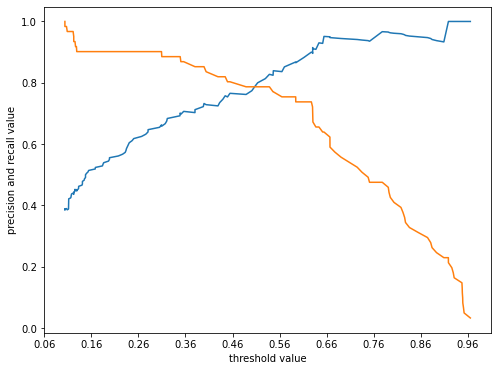

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#%matplotlib.inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('threshold value')
    plt.ylabel('precision and recall value')
    
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])
# 임곗값이 낮을수록 정밀도가 낮아져

## 4. F1 스코어

### 2 * precision * recall / (precision + recall)

In [52]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f1)

0.7804878048780488


In [54]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # f1 스코어 추가
    f1=f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값:  0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1:0.7786
임곗값:  0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값:  0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값:  0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값:  0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


## 5. ROC 곡선, AUC 점수
- x축: 1-특이도,  y축: 민감도 

In [55]:
# roc_curve(y_true, y_score(predict_proba의 positive 컬럼))
from sklearn.metrics import roc_curve

pred_proba_class1=lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0], 5)
print(thr_index)
print(np.round(thresholds[thr_index], 2))
print(np.round(fprs[thr_index], 3))
print(np.round(tprs[thr_index], 3))

[ 1  6 11 16 21 26 31 36 41 46 51]
[0.97 0.65 0.63 0.56 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
[0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
[0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


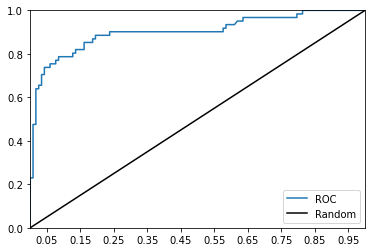

In [69]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],'k-',label = 'Random')
    
    start, end =plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [75]:
#AUC
from sklearn.metrics import roc_auc_score
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    #AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
        